## A/B - тестирование


Внутри увидите пример как формируются результаты по аб-тестированию. Прочтите сначала его, затем приступайте к выполнению задания.

В папке присутствует файл ab_test_ensembles.csv , который содержит реальные данные ab теста, когда-то проходившего у меня. Вам необходимо провести стандартный пайплайн, начав с ознакомления данных до вывода отчета. Условие гипотезы такое же как и в примере, нам необходимо нашим новым вариантом увеличить коэффициент конверсии на 2%, коэффициенты конверсии одинаковы с файлом из примера (плюс/минус) поэтому с этим проблем быть не должно. Условия гипотез теже.

В A/B тесте было два варианта работы сервиса - standard и svm_ensemble_v_1_22, где работала модель классификации пользователей.

Ответьте на 2 вопроса:

1. Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)
2. Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

Также необходимо провести небольшое EDA по представленному датасету, нарисовать два графика на ваш вкус.

---

**Баллы могут быть снижены** за качество кода - старайтесь чтобы код был максимально лаконичным. Названия переменных (если они используются) должны отражать максимальную ее сущность.

**Комментарии по сдаче практического задания**:
1. Залить в репу на github в папку module_2/ab_test_inference
2. Ссылку на репо отправлять мне на почту alexadevv@gmail.com не позднее дедлайна.
3. Тема письма: Домашнее задание по модулю 2 <Фамилия Имя>
4. После дедлайна, неотправленные на почту задания, оцениваются максимум в 7 баллов.

# 1. Дизайн эксперимента

У нас есть 2 версии продукта, новый и старый. Так же уже собраны данные для анализа. Н0 - нулевая гипотиза состоит в том, что новая версия продукта ничем не отличается от старой. Н1 - тестовая гипотеза, заключается в том, что новая версия старой отличается от старой. Наша главная и единственная метрика в данном тесте: конверсия. Значит её мы и будем сравнивать в двух версиях продукта. 

H0 : p = p0 
H1 : p != p0

где р и р0 - коэффициенты конверсии между новым и старым продуктом соответственно. Установленный уровень доверия 95%, следовательно р составляет 0.05.

Для проведения A/B тестирования нам необходимо 2 группы:

Контрольная (Control) группа - та группа пользователей, которым будет показываться старая версия сайта.
Эксперементальная (Treatment) группа - та группа пользователей, которым будет показываться новая версия сай

Нашей целевой переменной (Dependant Variable) будет выступать - уровень конверсии (conversion_rate). Целевая переменная представленна бинарно: 0 - пользователь не купил ничего в течение своей сессии на сайте 1 - пользователь купил продукт в течение своей сессии на сайте.та.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.stats.api as sms
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import ceil
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest, proportion_confint



# 2. Знакомство с датасетом
В данном пунке мы смотрим полученный датасет, смотрим на отсутствующие данные, сверяем группы

In [6]:
data = pd.read_csv('./ab_test_ensembles.csv')

In [7]:
data

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user
...,...,...,...,...,...,...,...,...
294473,497bf0f8-0092-4736-8ae7-775b6cc9736c,2022-05-03 22:28:38.630509,control,standard,0,United Kingdom,58+,new_user
294474,6cb20e62-e49d-41cf-97da-0e11cb439dca,2022-05-12 00:51:57.078372,control,standard,0,United Kingdom,42-49,new_user
294475,d307b0ad-92a1-409c-a2d2-da8f4a118576,2022-05-22 11:45:03.439544,control,standard,0,United Kingdom,18-25,registered_user
294476,c6bd8da5-2114-4fd4-92c6-e4b11a8be4dc,2022-05-15 01:20:28.957438,control,standard,0,United Kingdom,50-57,new_user


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [9]:
data.isnull().sum()

user_id      0
timestamp    0
group        0
variants     0
converted    0
location     0
age_group    0
user_type    0
dtype: int64

In [10]:
pd.crosstab(data['group'], data['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


In [11]:
data['variants'].value_counts()

variants
standard               147239
svm_ensemble_v_1_22    147239
Name: count, dtype: int64

In [12]:
sessions = data['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f'В таблице было найдено {duplicate_users} дубликатов')

В таблице было найдено 0 дубликатов


Видим, что наш датасет поделён поровну, и перебирая ID пользователей не обноружили ни одного дубликата

# 3. Визуализация и расчёт средних значений

In [15]:
conversion_rates = data.groupby('group')['converted']

# Стандартное отклонение
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg(['mean', std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.120399,0.325428,0.000848
treatment,0.118920,0.323694,0.000843


Из полученных расчётов видим, что стандартное отклонение и стандартная ошибка почти не отличается. Отличие заметно только в среднем значении: 12.03% и 11.89%
Визуализируем на графике

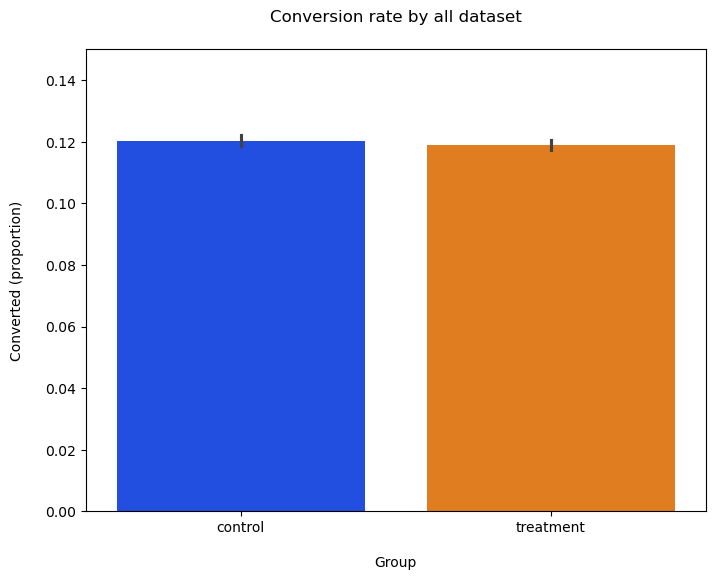

In [17]:
plt.figure(figsize=(8,6));
sns.barplot(x=data['group'], y=data['converted'], palette='bright', hue=data['group']);
plt.ylim(0, 0.15);
plt.title('Conversion rate by all dataset', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

# 4. Тестирование гипотезы

In [19]:
control_results = data[data['group'] == 'control']['converted']
treatment_results = data[data['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.24
p-value: 0.216
CI 95% for control group: [0.119, 0.122]
CI 95% for treatment group: [0.117, 0.121]


Исходя из проведённого A/B теста, результатом которого p-value: 0.216 оказался больше 0.05 можно сделать вывод, что мы не можем отклонить нулевую теорию, о том, что 2 версии сайта отличаются и влияют на конверсию.

Для дополнительной информации решил агрегировать пользователей с положительной конверсией по возросту.

In [22]:
data_age_group = pd.pivot_table( data, index='group', columns='age_group', values='converted', aggfunc = 'sum')
data_age_group

age_group,18-25,26-33,34-41,42-49,50-57,58+
group,,,,,,
control,2881,2992,2914,2962,2986,2988
treatment,2887,2968,2823,2912,2959,2965


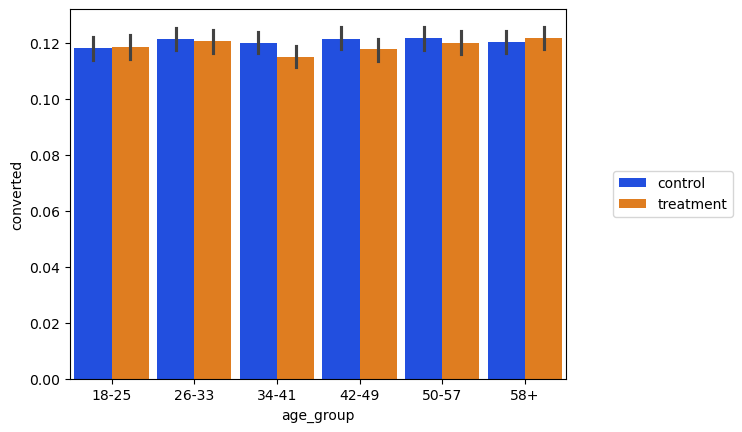

In [23]:
age_group = sns.barplot(x="age_group", y='converted', palette='bright', hue="group",
                data=data, width=0.9, legend='full',
                order=['18-25', '26-33', '34-41', '42-49', '50-57', '58+'],)
age_group.legend(loc='center right', bbox_to_anchor=(1.35, 0.5), ncol=1)

Конечно различия достаточно незначительны, но судя по графику можно сказать, что люди средней возростной группы сильнее отреагировали на новый вариант, и не в положительную для нас сторону.

# Проведём эксперимент для новых и зарегестрированных пользователей

In [26]:
data_age_group = pd.pivot_table( data, index='group', columns='user_type', values='converted', aggfunc = 'sum')
data_age_group

user_type,new_user,registered_user
group,,
control,8905,8818
treatment,8639,8875


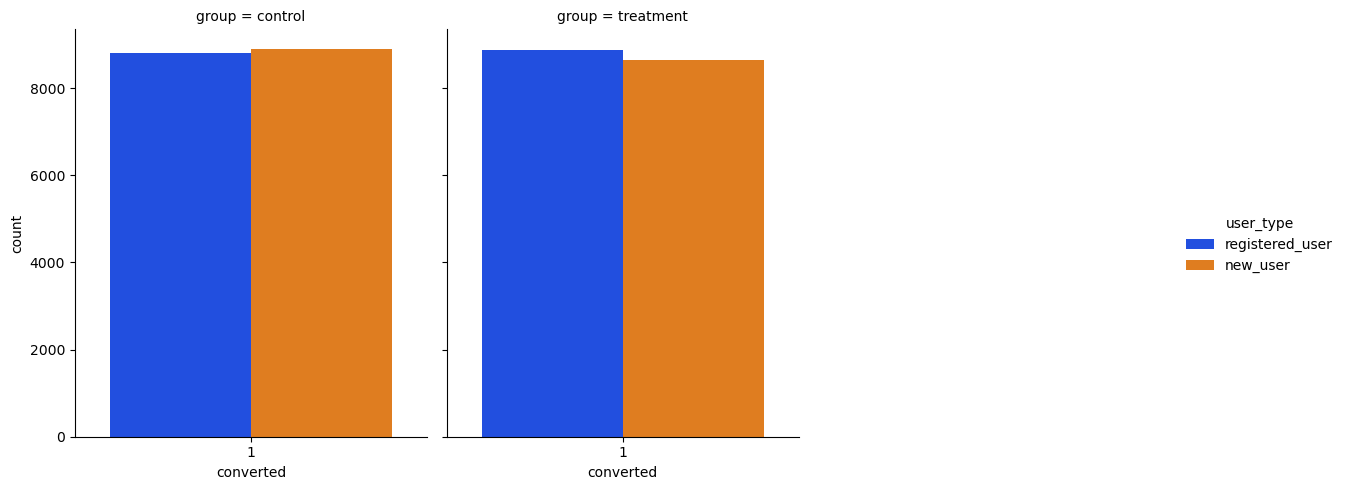

In [27]:
group = sns.catplot(x='converted', col="group", col_wrap=3, palette='bright', hue="user_type",
                data=data[data.converted == 1], 
                kind="count", height=5, aspect=.8,)

In [28]:
new_users_data = data[data.user_type == 'new_user']
reg_users_data = data[data.user_type == 'registered_user']
new_reg_users_data = pd.concat([new_users_data, reg_users_data], axis=0)
new_reg_users_data

,user_id,timestamp,group,variants,converted,location,age_group,user_type
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
8,070f398e-e6bf-43e7-88bb-37eff2cb9212,2022-05-04 17:58:08.979471,treatment,svm_ensemble_v_1_22,1,United Kingdom,18-25,new_user
9,9cff0b7e-d42b-4508-9fbe-a4e74f7f29c5,2022-05-15 18:11:06.610965,treatment,svm_ensemble_v_1_22,1,United Kingdom,26-33,new_user
11,1cc7ebbb-efb9-43a6-9230-11161ae910ba,2022-05-21 22:37:47.774891,treatment,svm_ensemble_v_1_22,0,United Kingdom,58+,new_user
14,137d7bf0-309c-4aad-ad9e-302a2f45dc70,2022-05-22 11:45:11.327945,treatment,svm_ensemble_v_1_22,0,United Kingdom,50-57,new_user
...,...,...,...,...,...,...,...,...
294464,9c1f18e9-b20f-4ef2-ae8d-3a190c93e5c3,2022-05-17 01:51:56.106436,control,standard,0,United Kingdom,34-41,registered_user
294468,873f6fd0-8f8b-47c9-b38e-b18b65262430,2022-05-02 19:20:05.460595,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
294470,bd11ea90-58e6-4e15-b9b7-1e45bb83475a,2022-05-11 02:42:21.195145,control,standard,0,United Kingdom,34-41,registered_user
294475,d307b0ad-92a1-409c-a2d2-da8f4a118576,2022-05-22 11:45:03.439544,control,standard,0,United Kingdom,18-25,registered_user


In [29]:
new_reg_users_data.group.value_counts(normalize=True)

group
treatment    0.500126
control      0.499874
Name: proportion, dtype: float64

Видим хорошее распределение новых и старых пользователей, можно сказать почти равное количество

In [31]:
conversion_rates = new_users_data.groupby('group')['converted']

# Стандартное отклонение для сформированной выборки
std_proportion_new_users = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки
se_proportion_new_users = lambda x: stats.sem(x, ddof=0)

conversion_rates_new_users = conversion_rates.agg(['mean', std_proportion_new_users, se_proportion_new_users]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates_new_users

,CR mean,CR std,CR se
group,,,
control,0.120746,0.325832,0.001200
treatment,0.117557,0.322082,0.001188


Здесь мы считаем среднее значение конверсии для новых пользователей, а так же стандартную ошибку и стандартное отклонение. Видим отличие в среднем значении конверсии 12.07% у контрольной группы и 11.75% у тестовой группы

In [33]:
conversion_rates = reg_users_data.groupby('group')['converted']

# Стандартное отклонение для сформированной выборки
std_proportion_reg_users = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки
se_proportion_reg_users = lambda x: stats.sem(x, ddof=0)

conversion_rates_new_users = conversion_rates.agg(['mean', std_proportion_new_users, se_proportion_new_users]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates_new_users

,CR mean,CR std,CR se
group,,,
control,0.120051,0.325021,0.001199
treatment,0.120277,0.325285,0.001197


А здесь мы считаем среднее значение конверсии для ранее зарегестрированных пользователей, а так же стандартную ошибку и стандартное отклонение. Видим отличие в среднем значении конверсии 12.005% у контрольной группы и 12.027% у тестовой группы, что почти не отиличимо.

Построим графики для новых и зарегестрированных пользователей

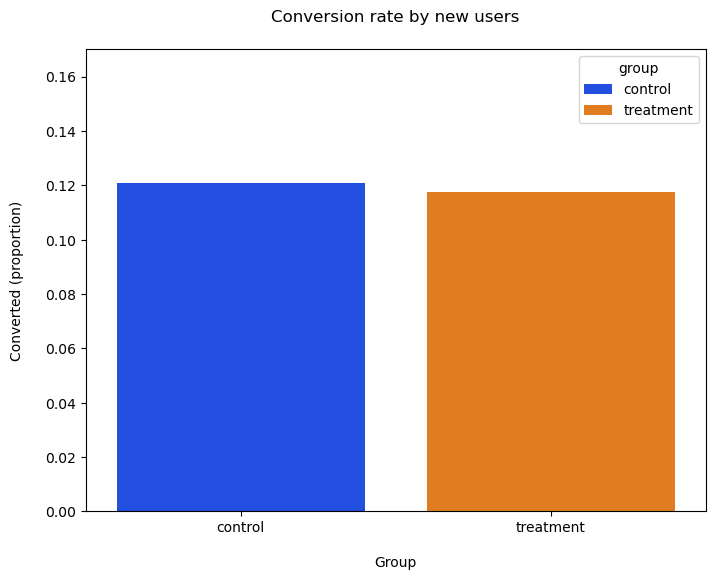

In [35]:
plt.figure(figsize=(8,6));
sns.barplot(x=new_users_data['group'], y=new_users_data['converted'], errorbar=('ci', False), 
            palette='bright', hue=data['group'], order=['control', 'treatment']);
plt.ylim(0, 0.17);
plt.title('Conversion rate by new users', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

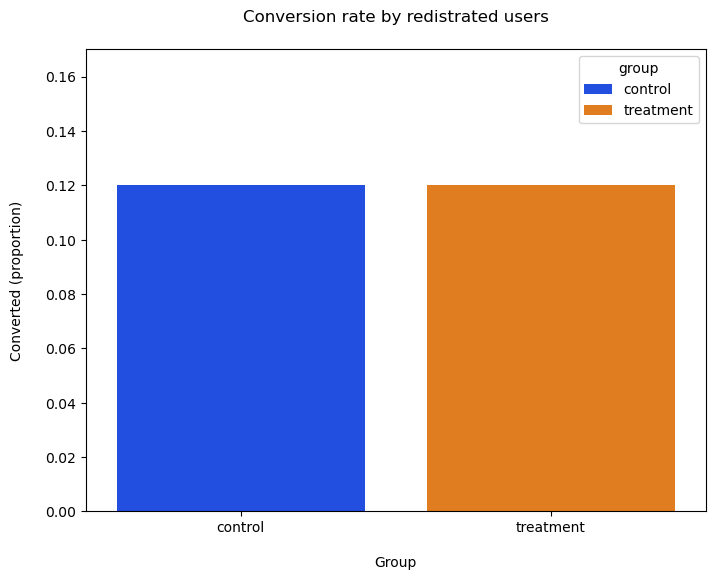

In [36]:
plt.figure(figsize=(8,6));
sns.barplot(x=reg_users_data['group'], y=reg_users_data['converted'], errorbar=('ci', False), 
            palette='bright', hue=data['group'], order=['control', 'treatment']);
plt.ylim(0, 0.17);
plt.title('Conversion rate by redistrated users', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

In [37]:
control_results = new_users_data[new_users_data['group'] == 'control']['converted']
treatment_results = new_users_data[new_users_data['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.89
p-value: 0.059
CI 95% for control group: [0.118, 0.123]
CI 95% for treatment group: [0.115, 0.120]


In [38]:
control_results = reg_users_data[reg_users_data['group'] == 'control']['converted']
treatment_results = reg_users_data[reg_users_data['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: -0.13
p-value: 0.894
CI 95% for control group: [0.118, 0.122]
CI 95% for treatment group: [0.118, 0.123]


# 5. Интерпритация результатов.

Исходя из полученных расчётов, можно сделать вовод, что для новых и для зарегестрированных пользователей значение p оказалось выше требуемого 0.05. При это можно заметить незначительную негативную тенденцию. Исходя из расчётов можно сделать следующий вывод:

1. Изменения которые были внесены, не имеют статистически значимого результата.
2. Внедрить новую версию можно, если нужно удовлетворить другие требования(на переработку потрачено много денег, новая версия выглядит лучше, новая версия упрощает внедрение других сервисов, которые не позволяла стартовая версия). Хотя этот вариант так же подрозумевает под собой продолжение работы над улучшением сервиса, так как хоть различия оказались статистически не значимы, но это небольшие различия есть и они не в лучшую сторону.
3. Так же можно оставить старую версию.

# Далее рассматриваем датасет под разными углами, что бы просмотреть допольнительную информацию

### Для эксперимента, попробуем сделать выборку как из примера, то есть расчитаем мощность эксперимента, на основании этого сделаем ещё один АБ тест, но для контрольно группы

In [43]:
effect_size = sms.proportion_effectsize(0.13, 0.15)
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1)
required_n = ceil(required_n)
print("Для каждой группы нам необходимо не меньше ",required_n, " наблюдений")

Для каждой группы нам необходимо не меньше  4720  наблюдений


In [44]:
control_sample = data[data['group'] == 'control'].sample(n = required_n, random_state=42)
treatment_sample = data[data['group'] == 'treatment'].sample(n = required_n, random_state=42)

# Сформируем общую случайную выборку
ab_df = pd.concat([control_sample, treatment_sample], axis=0)
ab_df.reset_index(drop=True, inplace=True)
ab_df.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,bcf8452b-3056-4d45-994f-5f286fd9869a,2022-05-18 04:44:18.590293,control,standard,0,United Kingdom,42-49,new_user
1,3c827a98-0868-4ce5-ac31-8195e243af37,2022-05-14 05:22:43.771772,control,standard,0,United Kingdom,50-57,new_user
2,71c72bb9-13d9-4755-b398-b2c5d8b1c4d6,2022-05-23 08:52:53.050325,control,standard,0,United Kingdom,34-41,new_user
3,654ee878-b0c5-4223-b9fb-995ca3d2eaf1,2022-05-07 23:27:09.109877,control,standard,0,United Kingdom,26-33,registered_user
4,1e044366-7e86-4d92-bba7-3afaa6f887f8,2022-05-20 14:26:10.133979,control,standard,0,United Kingdom,42-49,new_user


In [45]:
ab_df.shape

(9440, 8)

In [46]:
ab_df.group.value_counts(normalize=True)

group
control      0.5
treatment    0.5
Name: proportion, dtype: float64

In [47]:
conversion_rates = ab_df.groupby('group')['converted']

# Стандартное отклонение для сформированной выборки
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки, формулу стандартной ошибки вы знаете из лекций. Забыли - погуглите.
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg(['mean', std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.132415,0.338942,0.004933
treatment,0.119915,0.324862,0.004729


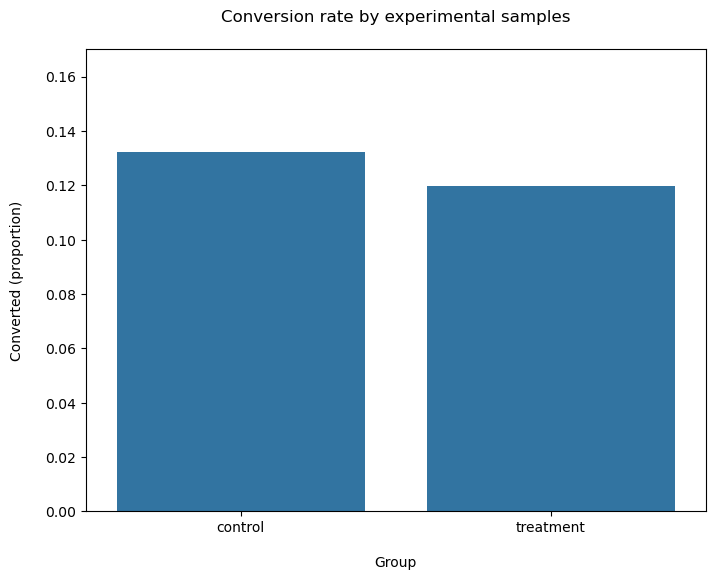

In [48]:
plt.figure(figsize=(8,6));
sns.barplot(x=ab_df['group'], y=ab_df['converted'], errorbar=('ci', False));
plt.ylim(0, 0.17);
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

In [49]:
control_results = ab_df[ab_df['group'] == 'control']['converted']
treatment_results = ab_df[ab_df['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.83
p-value: 0.067
CI 95% for control group: [0.123, 0.142]
CI 95% for treatment group: [0.111, 0.129]


Вывод. Уменьшив выборку, но сохранив мощность эксперимента мы убедились в статистической незначимости изменений, но всё же нужно отметить небольшую неготивную тенденцию.

### Разобьём наш датасет по дням недели и визуально оценим 2 группы

In [52]:
from datetime import datetime

In [53]:
days = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресение']

In [54]:
data['day_of_a_week'] = [days[datetime.fromisoformat(day).date().weekday()] for day in data['timestamp']]

In [55]:
data_day_of_a_week = data[['group', 'converted', 'day_of_a_week']]

In [56]:
data_day_of_a_week

,group,converted,day_of_a_week
0,control,0,Суббота
1,control,0,Четверг
2,treatment,0,Среда
3,treatment,0,Воскресение
4,control,1,Суббота
...,...,...,...
294473,control,0,Вторник
294474,control,0,Четверг
294475,control,0,Воскресение
294476,control,0,Воскресение


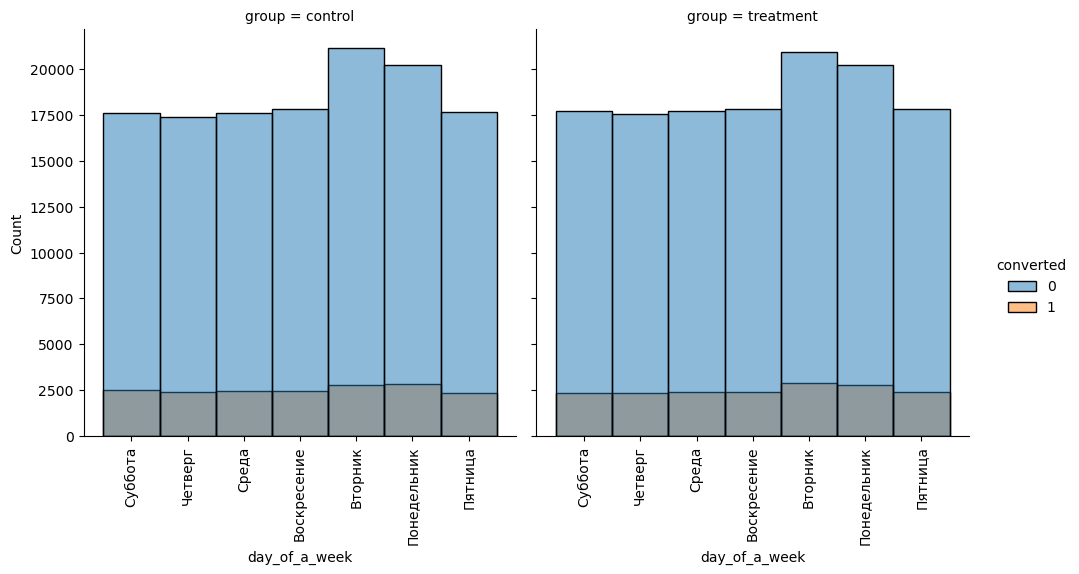

In [57]:
pr_pl = sns.displot(data_day_of_a_week, x="day_of_a_week", hue='converted', col="group")
pr_pl.set_xticklabels(rotation = 90)

Видим, что даже разбив датасет по дням денели мы не видим большой разнцицы между группами.